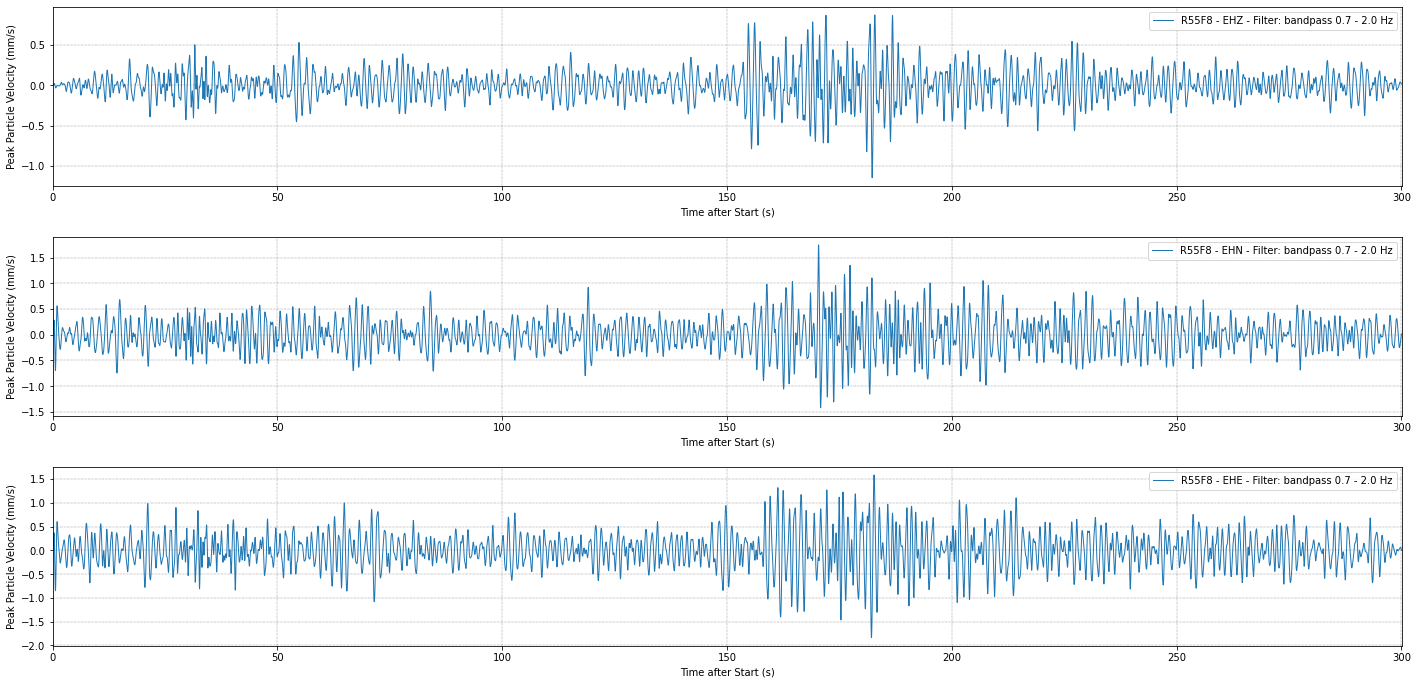

In [194]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read_inventory
import matplotlib.pyplot as plt
import numpy as np

### start user defined section ###

station = "R55F8" # code of the station

start_time = "2020-10-19T07:35:33.000" # start time for the plot
end_time = "2020-10-19T07:40:33.000" # end time for the plot

f1 = 0.7 # high-pass filter corner
f2 = 2.0 # low-pass filter corner 
cor = 4 # number of corners

### end user defined section ###

start_time = UTCDateTime(start_time)
end_time = UTCDateTime(end_time)

client = Client('http://fdsnws.raspberryshakedata.com') 
network = "AM"
loc = "00"
channels = ["EHZ", "EHN", "EHE"]
freq = int(100) # RS unit samples per second rate

try:

    # get inventory of the station to verify that a RS3D unit is being accessed    
    inv = read_inventory('https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?network=AM&station=%s&level=resp&format=xml&nodata=404&starttime=%s' % (station, str(start_time)))
    net = inv[0]
    sta = net[0]
   
    # generate figure    
    fig, axes = plt.subplots(figsize=(20, 10), nrows=3, ncols=1)
    fig.tight_layout(pad=3.0)
    
    # plot peak particle velocity charts for each channel of the RS3D unit    
    if len(list(sta)) == 3:
        for i, val in enumerate(channels):
            
            # download and process waveforms for each channel            
            st = client.get_waveforms(network, station, loc, val, starttime=start_time, endtime=end_time, attach_response=True)
            st.merge(method=0, fill_value='latest')
            st.detrend(type="demean")
            st.remove_response()
            st.filter("bandpass", freqmin=f1, freqmax=f2, corners=cor)
            
            # beautify the plots            
            axes[i].plot(st[0].times(reftime=start_time), 2*np.pi*freq*st[0].data*1000, lw=1)
            axes[i].margins(x=0.0001)
            axes[i].grid(color='dimgray', ls = '-.', lw = 0.33)
            axes[i].set_ylabel("Peak Particle Velocity (mm/s)")
            axes[i].set_xlabel("Time after Start (s)")
            staleg = str(station + " - " + val + " - " + "Filter: bandpass " + str(f1) + " - " + str(f2) + " Hz") 
            axes[i].legend([staleg])
            
        # save the final figure
        plt.savefig("PPVMotion_" + station + ".png")
    else:
        
        # if unit is not a RS3D, warn the user
        print("Please insert a RS3D Station.")
        
# print error messages instead of entire tracebacks
except Exception as e:
    
    if hasattr(e, 'message'):
        print(e.message)
    else:
        print(e)